# CS105 Final Project: Using Text Analysis on Movie Scripts to Predict Genre
### By: Tran Nguyen, Nina Shenoy, Carlos Miranda, Kathleen Dario

Our project idea stemmed from our collective love of movies. After learning about different machine learning + classification techniques in class, we questioned whether we could apply these concepts to movie scripts, and see if we could correctly predict the genre of a movie based on the words in it's script. The techniques we will use are tf-idf, KNN, and cosine similarity.

In [1]:
#Necessary imports for plotting, pandas, math operations, and multiple print statements.
import pandas as pd
from scipy.stats import chi2, chi2_contingency
from IPython.display import Image
import matplotlib.pyplot as plt
from math import pi
import numpy as np
import seaborn as sns
%matplotlib inline
import re

from wordcloud import WordCloud 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import enchant
enchant_dict = enchant.Dict("en_US")

import string

import nltk
#nltk.download('popular') download needed packagges
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')
evenmore_stopwords_list = ['like', 'well', 'oh', 'like', 'yeah', 'he\'s']
useless_words_list = ['know', 'knew', 'got', 'get', 'gonna']
stopwords_list_2 = ['go', 'right', 'come', 'good', 'okay', 'one', 'would', 'want', 'think', 'see', 'back', 'hey', 'i\'m', 'i\'ll', 'that\'s','he\'s', 'can\'t', 'said', 'this', 'going']   
stopwords_list = stopwords_list + evenmore_stopwords_list + useless_words_list + stopwords_list_2;

## 2. Data Collection & Data Cleaning
#### (Carlos Miranda + Nina Shenoy + Tran Ngueyn + Kathleen Dario)

We retrieved our data from 2 sources: IMDb and Kaggle. The IMDB datasets were used to obtain information about the movies title, genre(s), release date, language, etc. while the Kaggle dataset was used to retrieve the movie scripts. We used inner joins to combine the 3 datasets together, using the IMDB ID as the joining factor.

After combining our datasets, we then had to filter out any unneeded entries.  The IMDb datasets contained tens of thousands of movie entries, dating as far back to the 1800's. We decided that for this project, we will only use feature-length films (excludinv tv series, short-films, etc) that were released in the years (1960-2021) that are in English, and are from the regions of US and Canada. This signifigantly reduced the size of our original dataset, which made runtime faster and easier for us to analyze.

We also noticed that some movies had more than one entry. This was because there were instances where two scripts would correspond to a particular movie. To resolve this, we got rid of the longer script, as it contained unnecessary data such as exposition, cues, and character names, and we mainly wanted to focus on dialogue.

In [2]:
def cleanDF(df):
    df_copy = df.copy()
    filtered_words_x = ['go', 'right', 'come', 'good']
    df_copy['Scripts'] = df_copy['Scripts'].apply(lambda x: ' '.join([item for item in x.split() if item.lower() not in filtered_words_x]))
    return df_copy

In [3]:
def cleanCSV(scripts_basics_df, outputpath):
    #cleaning data
    scripts_basics_df = scripts_basics_df.dropna() #delete NaN values
    scripts_basics_df = scripts_basics_df.astype({'Scripts':'string'})

    scripts_basics_df["Scripts"] = scripts_basics_df["Scripts"].replace(to_replace=r"<.*>", value="", regex=True)
    scripts_basics_df["Scripts"] = scripts_basics_df["Scripts"].replace(to_replace=r"[^a-zA-Z0-9\'’\ ]", value="", regex=True)
    #scripts_basics_df['Scripts'] = scripts_basics_df['Scripts'].apply(lambda x: ' '.join([item for item in x.split() if not all([word in string.ascii_uppercase for word in item])]))
    scripts_basics_df['Scripts'] = scripts_basics_df['Scripts'].apply(lambda x: ' '.join([item for item in x.split() if item.lower() not in stopwords_list]))
    scripts_basics_df['Scripts'] = scripts_basics_df['Scripts'].apply(lambda x: ' '.join([item for item in x.split() if enchant_dict.check(item)]))
    #scripts_basics_df['Scripts']
    scripts_basics_df = scripts_basics_df[scripts_basics_df['Scripts'].str.split().str.len().ge(100)]
    scripts_basics_df = scripts_basics_df.dropna() #delete NaN values
    scripts_basics_df['Scripts'] = scripts_basics_df['Scripts'].str.lower()
    scripts_basics_df['Scripts'] = scripts_basics_df['Scripts'].apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords_list]))
    scripts_basics_df = scripts_basics_df.loc[:, ~scripts_basics_df.columns.str.startswith('Unnamed')] 
    scripts_basics_df.to_csv(outputpath)

In [4]:
def removeDuplicates(scripts_basics_df):
    # Key = IMDB ID , Value = Size of script
    smallestMovieScriptMap = {}
    # Key = IMDB ID , Value = index
    keepIndexMap = {}

    #show all columns
    scripts_basics_df.dtypes

    scripts_basics_df['Scripts'] = scripts_basics_df['Scripts'].apply(str)

    for index, row in scripts_basics_df.iterrows():
        constID = row['IMDB ID']
        currentSize = len(row['Scripts'])

        if constID in smallestMovieScriptMap:
            smallestSize = smallestMovieScriptMap[constID]
            if currentSize < smallestSize:
                smallestMovieScriptMap[constID] = currentSize
                keepIndexMap[constID] = index
        else:
            smallestMovieScriptMap[constID] = currentSize
            keepIndexMap[constID] = index
    # keep this removed, this removes first instance
    return scripts_basics_df[scripts_basics_df.index.isin(keepIndexMap.values())]

In [5]:
scripts_basics_df = pd.read_csv("datasets/bettermovies.csv")


Since some movies were classified as having multiple genres, we ended up splitting them into multiple entries in our data set, with each entry having one genre. This made it easier for us to calculate the frequencies of the different genres.

In [6]:
scripts_basics_df["genres"] = scripts_basics_df["genres"].str.split(",")
scripts_basics_df = scripts_basics_df.explode("genres")

## Exploratory Data Analysis (EDA)
#### (Nina Shenoy + Kathleen Dario)

Since our topic focuses heavily on genres and scripts, we wanted to see if we could find any relationships between these two variables. The three major things we focused on are:
1. The most common film genres in our dataset.
2. Which genre(s) have the most words in their scripts, and what the average script length is for that particular genre.
3. What the most common words are in each genre.

### What are the most common film genres in our dataset?

Drama          1136
Comedy          827
Action          593
Crime           474
Romance         406
Adventure       403
Thriller        362
Mystery         197
Fantasy         159
Sci-Fi          148
Biography       109
Animation       104
Family           94
Horror           72
Sport            63
Music            50
War              21
History          20
Western          17
Musical          13
Documentary       1
Name: genres, dtype: int64


<AxesSubplot:>

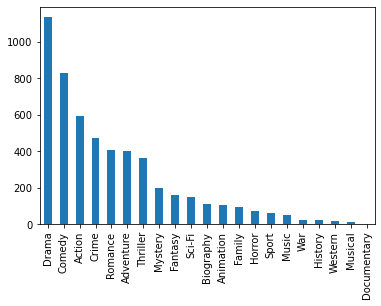

In [7]:
genre_frequency = scripts_basics_df.genres.value_counts()
print(genre_frequency)
genre_frequency.plot.bar()

As we can see per the above bar chart, the majority of the films in the dataset are classified as Drama, Comedy, and/or Action.

### Which genre(s) have the most words?

<AxesSubplot:title={'center':'Length'}, xlabel='genres'>

[Text(0, 0, 'Horror'),
 Text(1, 0, 'War'),
 Text(2, 0, 'Mystery'),
 Text(3, 0, 'Fantasy'),
 Text(4, 0, 'Thriller'),
 Text(5, 0, 'Action'),
 Text(6, 0, 'Sci-Fi'),
 Text(7, 0, 'Adventure'),
 Text(8, 0, 'Animation'),
 Text(9, 0, 'Western'),
 Text(10, 0, 'Drama'),
 Text(11, 0, 'Family'),
 Text(12, 0, 'Crime'),
 Text(13, 0, 'History'),
 Text(14, 0, 'Music'),
 Text(15, 0, 'Romance'),
 Text(16, 0, 'Musical'),
 Text(17, 0, 'Comedy'),
 Text(18, 0, 'Biography'),
 Text(19, 0, 'Sport'),
 Text(20, 0, 'Documentary')]

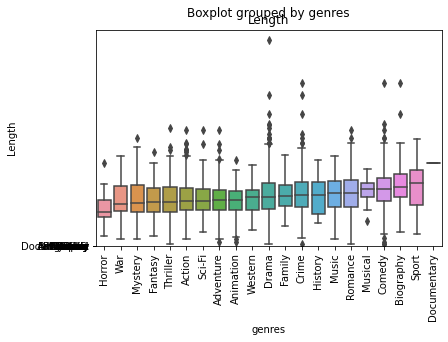

In [8]:
new_df = scripts_basics_df[["originalTitle", "Scripts", "genres"]]
new_df = new_df.dropna() #can be deleted since data should be clean before this step, kept for testing
new_df['Length'] = new_df['Scripts'].str.split(" ").str.len() # adds the length column with length of each script


new_df.boxplot(column='Length',by='genres', vert=False)

grouped = new_df.groupby(['genres']).median().sort_values(by='Length')

plot_df = sns.boxplot(x=new_df.genres, y=new_df.Length, order=grouped.index)
plot_df.set_xticklabels(plot_df.get_xticklabels(),rotation=90)

Special Notes: Documentary has the highest average length but it is also worth to note that there is an extremely small sample size. Horror, in this case, appears to have the smallest script length possibly due to trying to put emphasis on the environment.

### What are the most common words in each genre?

In [9]:
from collections import Counter

def cleanDF(df):
    df_copy = df.copy()
    filtered_words_x = ['go', 'right', 'come', 'good', 'okay', 'one', 'would', 'want', 'think', 'see', 'back', 'hey', 'i\'m', 'i\'ll', 'that\'s','he\'s', 'can\'t', 'said', 'this']    
    df_copy['Scripts'] = df_copy['Scripts'].apply(lambda x: ' '.join([item for item in x.split() if item.lower() not in filtered_words_x]))
    return df_copy

words_df = scripts_basics_df[["originalTitle", "Scripts", "genres"]]
words_df = words_df.dropna()
words_df = words_df.astype({'Scripts':'string'})
words_df = words_df.groupby(['genres']).agg({'Scripts': ' '.join})
words_df

clean_df = cleanDF(words_df)
clean_df["Most Common"] = pd.DataFrame({"MostCommon" : clean_df['Scripts'].str.split(" ").apply(lambda x: [k for k, v in Counter(x).most_common(10)])})
pd.set_option('display.max_colwidth', None)
display(clean_df[["Most Common"]])


,Scripts
genres,
Action,remember highlander remember free men planet h...
Adventure,suspenseful music playing time they've reached...
Animation,mom home five seconds already cooking l someth...
Biography,movie begin five moments mindless voice announ...
Comedy,time time proposed fourth dimension yet mortal...
Crime,irving makes cheap dago move weinberg man took...
Documentary,stakes high world hangs balance man man many t...
Drama,kissing goodbye four walls six flights six fli...
Family,captioning made possible warner bros lived not...


,Most Common
genres,
Action,"[man, us, we're, take, look, need, time, yes, tell, let's]"
Adventure,"[us, look, we're, man, yes, time, take, need, way, could]"
Animation,"[look, yes, us, we're, time, little, take, way, really, wait]"
Biography,"[man, yes, look, us, fucking, take, say, time, tell, we're]"
Comedy,"[look, really, man, yes, time, we're, take, say, love, little]"
Crime,"[man, look, take, tell, time, fucking, fuck, us, we're, need]"
Documentary,"[shit, fuck, man, put, house, kevin, say, fucking, people, look]"
Drama,"[man, look, time, yes, take, tell, say, us, really, need]"
Family,"[look, time, little, really, yes, take, we're, us, let's, man]"


In [10]:
from PIL import Image
mask = np.array(Image.open("heart.png"))

def printCloud(genre):
    wordcloud = WordCloud(width=1600, height=800).generate((clean_df.loc[genre, "Scripts"]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

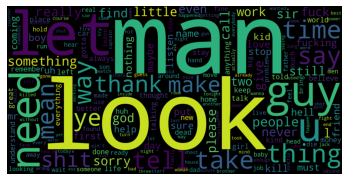

In [11]:
genres_list_o = {'Comedy', 'Fantasy', 'Romance', 'Drama', 'Thriller', 'Action', 'Crime', 'Adventure', 
     'Family', 'Mystery', 'Biography', 'Music', 'Horror', 'Sci-Fi', 'Animation',  
     'Sport', 'History',  'Western', 'War',  'Musical', 'Documentary'
}

#Get word cloud based on genre
for genre in genres_list_o:
    printCloud(genre)
    break; #get out of loop only for pdf report

## Analysis + Techniques
#### (Tran Nguyen)

### TF IDF 

After cleaning the dataset, we perform TF-IDF on the scripts to find the frequencies of each word in each script. The TF-IDF table above shows that there are a total of 58,420 unique words in the 2018 movie scripts we have. 

In [12]:
# read cleaned dataset
df = pd.read_csv("datasets/cleanest.csv")

# get only necessary columns 
main_df = df[["originalTitle", "Scripts", "genres"]]
main_df = main_df[main_df["Scripts"].str.contains("<NA>") == False].reset_index().drop("index", axis=1)

In [13]:
# tf idf 

from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

tfidf = TfidfVectorizer()
response = tfidf.fit_transform(main_df["Scripts"])
feature_names = tfidf.get_feature_names()
vectorized_df = pd.DataFrame(response.toarray()).set_axis(feature_names, axis=1)
vectorized_df.head()

,00,000,0000,00000,00001,0002,000500010000,001,0010,0012,...,zounds,zs,zucchini,zulu,zulus,zuni,zurich,zwieback,zygote,zzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### K-Nearest Neighbors

For predicting the genres of our movies, we use K-Nearest Neighbor as our classifier. The classifying process is as followed:

We first use the Train-Test Split technique to split the dataset into two sets: 
    - one for training, which contains the neighbors for KNN
    - one for testing, which contains the new instances we want to add to our data
1800 out of 2018 scripts, or 89% of the dataset, are used for training. The rest is used for testing.

In [14]:
# edit vectorized dataframe
vectorized_df.insert(0, "movie_genres", main_df["genres"].copy())
vectorized_df.insert(0, "movie_titles", main_df["originalTitle"].copy())

# divide into train and test
vectorized_train = vectorized_df.loc[:1800].copy()
vectorized_test = vectorized_df.loc[1801:].copy()
vectorized_train.head()

,movie_titles,movie_genres,00,000,0000,00000,00001,0002,000500010000,001,...,zounds,zs,zucchini,zulu,zulus,zuni,zurich,zwieback,zygote,zzz
0,Kate & Leopold,"Comedy,Fantasy,Romance",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Backdraft,"Action,Crime,Drama",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Barton Fink,"Comedy,Drama,Thriller",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bill & Ted's Bogus Journey,"Adventure,Comedy,Fantasy",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Billy Bathgate,"Crime,Drama,Thriller",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Looking at the above training set, we can see that movies can have multiple genres. Thus we want to separate the genres for training purposes. Any movie with multiple genres will have multiple instances in the training set, each instance with one genre.

In [15]:
# splitting genres only for train
vectorized_train["movie_genres"] = vectorized_train["movie_genres"].squeeze().str.split(",")
vectorized_train = vectorized_train.explode("movie_genres")
vectorized_train.head()

,movie_titles,movie_genres,00,000,0000,00000,00001,0002,000500010000,001,...,zounds,zs,zucchini,zulu,zulus,zuni,zurich,zwieback,zygote,zzz
0,Kate & Leopold,Comedy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,Kate & Leopold,Fantasy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,Kate & Leopold,Romance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Backdraft,Action,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Backdraft,Crime,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that each row has only one genre, we take a look at the distribution of our training set. Our dataset has a very skewed distribution: there are 1021 Drama movies while there are only 9 Western movies.
Having even distribution of neighbors would help with our classifier's performance. Thus, we only select the top 7 genres that have enough data for our classification and discard the rest. For each of these 7 genres, 300 movies are selected for the training set.

In [16]:
vectorized_train["movie_genres"].value_counts()

# get 250 movies for each genre (Drama, Comedy, Action, Crime, Romance, Adventure, Thriller)
vectorized_train["movie_genres"].value_counts()
sorted_df = vectorized_train.sort_values(by=['movie_genres'], ascending=True)

not_remove = {'Action', 'Adventure', 'Comedy', 'Crime', 'Drama',  'Romance', 'Thriller'}
remove = {'Mystery', 'Fantasy', 'Sci-Fi', 'Biography', 'Animation', 'Family', 'Horror',  'Sport', 'Music', 'War', 'History', 'Musical', 'Western', 'Documentary'}

sorted_df = sorted_df[~sorted_df["movie_genres"].isin(remove)]

vectorized_train = vectorized_train.iloc[0:0]
for x in not_remove:
    temp = sorted_df.loc[sorted_df["movie_genres"] == x]
    vectorized_train = vectorized_train.append(temp.iloc[:300])

# get list of movies used for training (so we dont use them in testing)
train_movies = list(set(vectorized_train["movie_titles"].tolist()))
vectorized_train.head()

Drama        1020
Comedy        747
Action        510
Crime         430
Romance       385
Adventure     360
Thriller      316
Mystery       181
Fantasy       143
Sci-Fi        135
Biography      95
Animation      91
Family         88
Horror         65
Sport          56
Music          43
History        15
War            14
Musical        12
Western         8
Name: movie_genres, dtype: int64

Drama        1020
Comedy        747
Action        510
Crime         430
Romance       385
Adventure     360
Thriller      316
Mystery       181
Fantasy       143
Sci-Fi        135
Biography      95
Animation      91
Family         88
Horror         65
Sport          56
Music          43
History        15
War            14
Musical        12
Western         8
Name: movie_genres, dtype: int64

,movie_titles,movie_genres,00,000,0000,00000,00001,0002,000500010000,001,...,zounds,zs,zucchini,zulu,zulus,zuni,zurich,zwieback,zygote,zzz
1579,The Greatest Showman,Drama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1564,The American,Drama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1656,Cut Bank,Drama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1050,The Great Debaters,Drama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394,The Rainmaker,Drama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Currently, our genres are categorical variables. To perform KNN and make predictions, we must convert them into numerical values:

In [17]:
# convert "genres" from categorical to quantitative
d = {'Action': 0, 'Adventure': 1, 'Comedy': 2, 'Crime': 3, 'Drama': 4,  'Romance': 5, 'Thriller': 6}

vectorized_train["movie_genres"] = vectorized_train["movie_genres"].map(d)
vectorized_train.head()

,movie_titles,movie_genres,00,000,0000,00000,00001,0002,000500010000,001,...,zounds,zs,zucchini,zulu,zulus,zuni,zurich,zwieback,zygote,zzz
1579,The Greatest Showman,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1564,The American,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1656,Cut Bank,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1050,The Great Debaters,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394,The Rainmaker,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For the purposes of evaluating our classifier's performance, we also separate the genres of the testing set and convert them into numerical values. For each movie, the original string of genres is converted into a list of numerical genres.

In [18]:
# Convert genres in test set to numbers and put them into lists
vectorized_test.head()

# remove movies that are in train set from test set
test_movies = list(set(vectorized_test["movie_titles"].tolist()))
for x in list(set(test_movies).intersection(train_movies)):
    vectorized_test = vectorized_test[vectorized_test["movie_titles"] != x]

# split movie_genres into one genre per line
vectorized_test_temp = vectorized_test.copy()
vectorized_test_temp["movie_genres"] = vectorized_test_temp["movie_genres"].squeeze().str.split(",")
vectorized_test_temp = vectorized_test_temp.explode("movie_genres")

# filter out movies from test set that don't have the genres we're keeping
for x in remove:
    vectorized_test = vectorized_test[vectorized_test["movie_genres"] != x]
    vectorized_test_temp = vectorized_test_temp[vectorized_test_temp["movie_genres"] != x]
    
# convert genres to numbers and put them into lists
vectorized_test_temp["movie_genres"] = vectorized_test_temp["movie_genres"].map(d)
vectorized_test_temp = vectorized_test_temp.groupby("movie_titles")["movie_genres"].apply(list).reset_index()

# change string genres to list of numerical genres
vectorized_test = vectorized_test.sort_values(by=['movie_titles'], ascending=True)
vectorized_test_temp = vectorized_test_temp.sort_values(by=['movie_titles'], ascending=True)
vectorized_test["movie_genres"] = vectorized_test_temp["movie_genres"].values
vectorized_test.head()

,movie_titles,movie_genres,00,000,0000,00000,00001,0002,000500010000,001,...,zounds,zs,zucchini,zulu,zulus,zuni,zurich,zwieback,zygote,zzz
1801,Pixels,"Action,Comedy,Fantasy",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1802,Collide,"Action,Crime,Thriller",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1803,Jane Got a Gun,"Action,Drama,Western",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1804,The Accountant,"Action,Thriller",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.010489,0.0,0.0,0.087146
1805,St. Vincent,"Comedy,Drama",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


,movie_titles,movie_genres,00,000,0000,00000,00001,0002,000500010000,001,...,zounds,zs,zucchini,zulu,zulus,zuni,zurich,zwieback,zygote,zzz
1807,3 Days to Kill,"[0, 4, 6]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1918,5 Flights Up,"[2, 4]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2071,A Bad Moms Christmas,[2],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1910,A Fighting Man,[4],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1898,A Little Chaos,"[4, 5]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### KNN using Jaccard Similarity and Cosine Similarity

With our training and testing sets ready, we go ahead and perform our classification.
- We choose the value k = sqrt(n), where n is the size of our training test
- To calculate the distance of the new instance and its k neighbors, or in our context, the similarity of one script with its neighbors, we use two similarity measuring methods: Cosine Similarity and Jaccard similarity
- We also use weighted distance method during our similarity calculation to aim for a better performance.

In [19]:
from sklearn.neighbors import KNeighborsClassifier 
from numpy import dot
from numpy.linalg import norm
import math

X_train = vectorized_train.copy().drop(["movie_titles", "movie_genres"], axis=1)
y_train = vectorized_train["movie_genres"]
X_test = vectorized_test.copy().drop(["movie_titles", "movie_genres"], axis=1)
y_test = vectorized_test["movie_genres"]

# cosine similarity calculation
def cos_sim(x, y):
    return dot(x, y) / (norm(x) * norm(y))

k = int(math.sqrt(X_train.shape[0]))
# knn_model = KNeighborsClassifier(n_neighbors=k, metric=cos_sim)
knn_model = KNeighborsClassifier(n_neighbors=k, metric="jaccard")
# knn_model = KNeighborsClassifier(n_neighbors=k, weights='distance', metric="jaccard")

knn_model.fit(X=X_train, y=y_train)

KNeighborsClassifier(metric='jaccard', n_neighbors=45)

In [20]:
# comparing predicted genre with actual genres

# pd.set_option('display.max_rows', None)
test_preds = knn_model.predict(X_test)
compare = vectorized_test[["movie_titles","movie_genres"]]
compare = compare.assign(predicted = pd.Series(test_preds).values)
compare

C:\Users\Kotori\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


,movie_titles,movie_genres,predicted
1807,3 Days to Kill,"[0, 4, 6]",4
1918,5 Flights Up,"[2, 4]",2
2071,A Bad Moms Christmas,[2],2
1910,A Fighting Man,[4],4
1898,A Little Chaos,"[4, 5]",1
...,...,...,...
2061,Wonder Wheel,"[4, 5]",5
2048,Wonderstruck,"[1, 4]",4
1950,X-Men: Apocalypse,"[0, 1]",0
1995,Yoga Hosers,"[0, 2]",2


After many tests, the method that gives our classifier the best performance is to use $k = sqrt(n)$ and Jaccard Similarity without weighted distances. This gives us an accurancy of 64% to predict the genre of the 200 movies in our testing set.

In [21]:
# evaluate the performance of our model

# compute the error percentage of two arrays
# actual is an array of arrays of numbers
# predicted is an array of numbers
# return the number of correct predictions/total
def error_perc(actual, predicted):
    correct = 0;
    for x, y in zip(actual, predicted):
        for i in x:
            if y == i:
                correct = correct + 1
                # print(x, y)
                # print(str(correct) + ", " + str(len(actual)))
    return correct / len(actual)

ep = error_perc(y_test, test_preds)
ep

0.6236162361623616

In conclusion, we were able to get a 62% accuracy on our prediction model which is a good start at predicting movie genres based on their script. We can begin to improve our model by using K-Means to see how unsupervised learning can affect our results. We could also improve our data cleaning system by adding more stop words to filter out. Another step for improvement could be increasing our number of movies so our movie genres are more evenly distributed. 

#### Contributions

Data Cleaning:
Tran Nguyen, Nina Shenoy, Carlos Miranda, Kathleen Dario

EDA:
Nina Shenoy, Kathleen Dario   

Analysis:
Carlos Miranda, Tran Nguyen